In [2]:
from argparse import Namespace
from collections import Counter
import json
import os
import re
import string

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

In [3]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, add_unk=True, unk_token="<UNK>"):
        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [4]:
class ReviewVectorizer(object):
    def __init__(self, review_vocab, rating_vocab):
        self.review_vocab = review_vocab
        self.rating_vocab = rating_vocab

    def vectorize(self, review):
        one_hot = np.zeros(len(self.review_vocab), dtype=np.float32)
        
        for token in review.split(" "):
            if token not in string.punctuation:
                one_hot[self.review_vocab.lookup_token(token)] = 1

        return one_hot

    @classmethod
    def from_dataframe(cls, review_df, cutoff=25):
        review_vocab = Vocabulary(add_unk=True)
        rating_vocab = Vocabulary(add_unk=False)
        
        for rating in sorted(set(review_df.rating)):
            rating_vocab.add_token(rating)

        word_counts = Counter()
        for review in review_df.review:
            for word in review.split(" "):
                if word not in string.punctuation:
                    word_counts[word] += 1
               
        for word, count in word_counts.items():
            if count > cutoff:
                review_vocab.add_token(word)

        return cls(review_vocab, rating_vocab)

    @classmethod
    def from_serializable(cls, contents):
        review_vocab = Vocabulary.from_serializable(contents['review_vocab'])
        rating_vocab =  Vocabulary.from_serializable(contents['rating_vocab'])

        return cls(review_vocab=review_vocab, rating_vocab=rating_vocab)

    def to_serializable(self):
        return {'review_vocab': self.review_vocab.to_serializable(),
                'rating_vocab': self.rating_vocab.to_serializable()}

In [5]:
class ReviewDataset(Dataset):
    def __init__(self, review_df, vectorizer):
        self.review_df = review_df
        self._vectorizer = vectorizer

        self.train_df = self.review_df[self.review_df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.review_df[self.review_df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.review_df[self.review_df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, review_csv):
        review_df = pd.read_csv(review_csv)
        train_review_df = review_df[review_df.split=='train']
        return cls(review_df, ReviewVectorizer.from_dataframe(train_review_df))
    
    @classmethod
    def load_dataset_and_load_vectorizer(cls, review_csv, vectorizer_filepath):
        review_df = pd.read_csv(review_csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(review_df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return ReviewVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer

    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        review_vector = \
            self._vectorizer.vectorize(row.review)

        rating_index = \
            self._vectorizer.rating_vocab.lookup_token(row.rating)

        return {'x_data': review_vector,
                'y_target': rating_index}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size  
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"):
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

In [6]:
class ReviewClassifier(nn.Module):
    def __init__(self, num_features):
        super(ReviewClassifier, self).__init__()
        self.fc1 = nn.Linear(in_features=num_features, 
                             out_features=1)

    def forward(self, x_in, apply_sigmoid=False):
        y_out = self.fc1(x_in).squeeze()
        if apply_sigmoid:
            y_out = torch.sigmoid(y_out)
        return y_out

In [7]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):

    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        if loss_t >= train_state['early_stopping_best_val']:
            train_state['early_stopping_step'] += 1
        else:
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            train_state['early_stopping_step'] = 0

        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    y_target = y_target.cpu()
    y_pred_indices = (torch.sigmoid(y_pred)>0.5).cpu().long()#.max(dim=1)[1]
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [8]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

In [9]:
args = Namespace(
    frequency_cutoff=25,
    model_state_file='model.pth',
    review_csv='data/y/reviews_with_splits_lite.csv',
    save_dir='model_storage/c/y/',
    vectorizer_file='vectorizer.json',
    batch_size=128,
    early_stopping_criteria=5,
    learning_rate=0.001,
    num_epochs=100,
    seed=1337,
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")

set_seed_everywhere(args.seed, args.cuda)

handle_dirs(args.save_dir)

Expanded filepaths: 
	model_storage/c/y/vectorizer.json
	model_storage/c/y/model.pth
Using CUDA: False


In [10]:
if args.reload_from_files:
    print("Loading dataset and vectorizer")
    dataset = ReviewDataset.load_dataset_and_load_vectorizer(args.review_csv,
                                                            args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = ReviewDataset.load_dataset_and_make_vectorizer(args.review_csv)
    dataset.save_vectorizer(args.vectorizer_file)    
vectorizer = dataset.get_vectorizer()

classifier = ReviewClassifier(num_features=len(vectorizer.review_vocab))

Loading dataset and creating vectorizer


In [11]:
classifier = classifier.to(args.device)

loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)

train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            optimizer.zero_grad()

            y_pred = classifier(x_in=batch_dict['x_data'].float())

            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            loss.backward()

            optimizer.step()
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            train_bar.set_postfix(loss=running_loss, 
                                  acc=running_acc, 
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            y_pred = classifier(x_in=batch_dict['x_data'].float())

            loss = loss_func(y_pred, batch_dict['y_target'].float())
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            val_bar.set_postfix(loss=running_loss, 
                                acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")

/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/malinroot/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Exiting loop


In [19]:
classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    y_pred = classifier(x_in=batch_dict['x_data'].float())

    loss = loss_func(y_pred, batch_dict['y_target'].float())
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc

In [14]:
print("Test loss: {:.3f}".format(train_state['test_loss']))
print("Test Accuracy: {:.2f}".format(train_state['test_acc']))

Test loss: 0.215
Test Accuracy: 91.90


In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text

In [16]:
def predict_rating(review, classifier, vectorizer, decision_threshold=0.5):
    review = preprocess_text(review)
    
    vectorized_review = torch.tensor(vectorizer.vectorize(review))
    result = classifier(vectorized_review.view(1, -1))
    
    probability_value = F.sigmoid(result).item()
    index = 1
    if probability_value < decision_threshold:
        index = 0

    return vectorizer.rating_vocab.lookup_index(index)

In [17]:
test_review = "this is a pretty awesome book"

classifier = classifier.cpu()
prediction = predict_rating(test_review, classifier, vectorizer, decision_threshold=0.5)
print("{} -> {}".format(test_review, prediction))

this is a pretty awesome book -> positive


/home/malinroot/.local/lib/python3.7/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [18]:
classifier.fc1.weight.shape

torch.Size([1, 7326])

In [13]:
fc1_weights = classifier.fc1.weight.detach()[0]
_, indices = torch.sort(fc1_weights, dim=0, descending=True)
indices = indices.numpy().tolist()

print("Influential words in Positive Reviews:")
print("--------------------------------------")
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))
    
print("====\n\n\n")

print("Influential words in Negative Reviews:")
print("--------------------------------------")
indices.reverse()
for i in range(20):
    print(vectorizer.review_vocab.lookup_index(indices[i]))

Influential words in Positive Reviews:
--------------------------------------
delicious
fantastic
pleasantly
amazing
great
vegas
excellent
yum
perfect
awesome
yummy
ngreat
love
bomb
solid
chinatown
wonderful
pleased
deliciousness
notch
====



Influential words in Negative Reviews:
--------------------------------------
worst
mediocre
bland
horrible
meh
awful
rude
terrible
tasteless
overpriced
disgusting
poorly
unfriendly
unacceptable
slowest
nmaybe
disappointing
disappointment
downhill
underwhelmed


In [1]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [2]:
args = Namespace(
    raw_train_dataset_csv="data/y/raw_train.csv",
    raw_test_dataset_csv="data/y/raw_test.csv",
    train_proportion=0.7,
    val_proportion=0.3,
    output_munged_csv="data/y/reviews_with_splits_full.csv",
    seed=1337
)

In [3]:
train_reviews = pd.read_csv(args.raw_train_dataset_csv, header=None, names=['rating', 'review'])
train_reviews = train_reviews[~pd.isnull(train_reviews.review)]
test_reviews = pd.read_csv(args.raw_test_dataset_csv, header=None, names=['rating', 'review'])
test_reviews = test_reviews[~pd.isnull(test_reviews.review)]

In [4]:
train_reviews.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [5]:
test_reviews.head()

,rating,review
0,1,Ordered a large Mango-Pineapple smoothie. Stay...
1,2,Quite a surprise! \n\nMy wife and I loved thi...
2,1,"First I will say, this is a nice atmosphere an..."
3,2,I was overall pretty impressed by this hotel. ...
4,1,Video link at bottom review. Worst service I h...


In [6]:
set(train_reviews.rating)

{1, 2}

In [8]:
by_rating = collections.defaultdict(list)
for _, row in train_reviews.iterrows():
    by_rating[row.rating].append(row.to_dict())

In [9]:
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    
    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'

    final_list.extend(item_list)

In [10]:
for _, row in test_reviews.iterrows():
    row_dict = row.to_dict()
    row_dict['split'] = 'test'
    final_list.append(row_dict)


In [11]:
final_reviews = pd.DataFrame(final_list)

In [12]:
final_reviews.split.value_counts()

train    392000
val      168000
test      38000
Name: split, dtype: int64

In [13]:
final_reviews.review.head()

0    The entrance was the #1 impressive thing about...
1    I'm a Mclover, and I had no problem\nwith the ...
2    Less than good here, not terrible, but I see n...
3    I don't know if I can ever bring myself to go ...
4    Food was OK/Good but the service was terrible....
Name: review, dtype: object

In [14]:
final_reviews[pd.isnull(final_reviews.review)]

,rating,review,split


In [15]:
def preprocess_text(text):
    if type(text) == float:
        print(text)
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
final_reviews.review = final_reviews.review.apply(preprocess_text)

In [16]:
final_reviews['rating'] = final_reviews.rating.apply({1: 'negative', 2: 'positive'}.get)

In [17]:
final_reviews.head()

,rating,review,split
0,negative,the entrance was the impressive thing about th...,train
1,negative,"i m a mclover , and i had no problem nwith the...",train
2,negative,"less than good here , not terrible , but i see...",train
3,negative,i don t know if i can ever bring myself to go ...,train
4,negative,food was ok good but the service was terrible ...,train


In [18]:
final_reviews.to_csv(args.output_munged_csv, index=False)

In [1]:
import collections
import numpy as np
import pandas as pd
import re

from argparse import Namespace

In [2]:
args = Namespace(
    raw_train_dataset_csv="data/y/raw_train.csv",
    raw_test_dataset_csv="data/y/raw_test.csv",
    proportion_subset_of_train=0.1,
    train_proportion=0.7,
    val_proportion=0.15,
    test_proportion=0.15,
    output_munged_csv="data/y/reviews_with_splits_lite.csv",
    seed=1337
)

In [3]:
train_reviews = pd.read_csv(args.raw_train_dataset_csv, header=None, names=['rating', 'review'])

In [4]:
by_rating = collections.defaultdict(list)
for _, row in train_reviews.iterrows():
    by_rating[row.rating].append(row.to_dict())
    
review_subset = []

for _, item_list in sorted(by_rating.items()):

    n_total = len(item_list)
    n_subset = int(args.proportion_subset_of_train * n_total)
    review_subset.extend(item_list[:n_subset])

review_subset = pd.DataFrame(review_subset)

In [5]:
review_subset.head()

,rating,review
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,1,I don't know what Dr. Goldberg was like before...
2,1,I'm writing this review to give you a heads up...
3,1,Wing sauce is like water. Pretty much a lot of...
4,1,Owning a driving range inside the city limits ...


In [6]:
train_reviews.rating.value_counts()

2    280000
1    280000
Name: rating, dtype: int64

In [7]:
review_subset.rating.value_counts()

2    28000
1    28000
Name: rating, dtype: int64

In [8]:
set(review_subset.rating)


{1, 2}

In [9]:
by_rating = collections.defaultdict(list)
for _, row in review_subset.iterrows():
    by_rating[row.rating].append(row.to_dict())
    
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)

    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    final_list.extend(item_list)

In [10]:
final_list = []
np.random.seed(args.seed)

for _, item_list in sorted(by_rating.items()):

    np.random.shuffle(item_list)
    
    n_total = len(item_list)
    n_train = int(args.train_proportion * n_total)
    n_val = int(args.val_proportion * n_total)
    n_test = int(args.test_proportion * n_total)

    for item in item_list[:n_train]:
        item['split'] = 'train'
    
    for item in item_list[n_train:n_train+n_val]:
        item['split'] = 'val'
        
    for item in item_list[n_train+n_val:n_train+n_val+n_test]:
        item['split'] = 'test'

    final_list.extend(item_list)

In [11]:
final_reviews = pd.DataFrame(final_list)

In [12]:
final_reviews.split.value_counts()

train    39200
val       8400
test      8400
Name: split, dtype: int64

In [13]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"([.,!?])", r" \1 ", text)
    text = re.sub(r"[^a-zA-Z.,!?]+", r" ", text)
    return text
    
final_reviews.review = final_reviews.review.apply(preprocess_text)

In [14]:
final_reviews['rating'] = final_reviews.rating.apply({1: 'negative', 2: 'positive'}.get)

In [15]:
final_reviews.head()

,rating,review,split
0,negative,all i can say is that a i had no other option ...,train
1,negative,i went here once when my long time stylist mov...,train
2,negative,i don t know why i stopped here for lunch this...,train
3,negative,did i order the wrong thing ? or maybe it was ...,train
4,negative,i went here for restaurant week . the restaura...,train


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

%matplotlib inline

In [17]:
LEFT_CENTER = (3, 3)
RIGHT_CENTER = (3, -2)

In [18]:
class Perceptron(nn.Module):
    def __init__(self, input_dim):

        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):

        return torch.sigmoid(self.fc1(x_in))

In [19]:
def get_toy_data(batch_size, left_center=LEFT_CENTER, right_center=RIGHT_CENTER):
    x_data = []
    y_targets = np.zeros(batch_size)
    for batch_i in range(batch_size):
        if np.random.random() > 0.5:
            x_data.append(np.random.normal(loc=left_center))
        else:
            x_data.append(np.random.normal(loc=right_center))
            y_targets[batch_i] = 1
    return torch.tensor(x_data, dtype=torch.float32), torch.tensor(y_targets, dtype=torch.float32)

In [20]:
def visualize_results(perceptron, x_data, y_truth, n_samples=1000, ax=None, epoch=None, 
                      title='', levels=[0.3, 0.4, 0.5], linestyles=['--', '-', '--']):
    y_pred = perceptron(x_data)
    y_pred = (y_pred > 0.5).long().data.numpy().astype(np.int32)

    x_data = x_data.data.numpy()
    y_truth = y_truth.data.numpy().astype(np.int32)

    n_classes = 2

    all_x = [[] for _ in range(n_classes)]
    all_colors = [[] for _ in range(n_classes)]
    
    colors = ['black', 'white']
    markers = ['o', '*']
    
    for x_i, y_pred_i, y_true_i in zip(x_data, y_pred, y_truth):
        all_x[y_true_i].append(x_i)
        if y_pred_i == y_true_i:
            all_colors[y_true_i].append("white")
        else:
            all_colors[y_true_i].append("black")

    all_x = [np.stack(x_list) for x_list in all_x]

    if ax is None:
        _, ax = plt.subplots(1, 1, figsize=(10,10))
        
    for x_list, color_list, marker in zip(all_x, all_colors, markers):
        ax.scatter(x_list[:, 0], x_list[:, 1], edgecolor="black", marker=marker, facecolor=color_list, s=300)
    
        
    xlim = (min([x_list[:,0].min() for x_list in all_x]), 
            max([x_list[:,0].max() for x_list in all_x]))
            
    ylim = (min([x_list[:,1].min() for x_list in all_x]), 
            max([x_list[:,1].max() for x_list in all_x]))

    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = perceptron(torch.tensor(xy, dtype=torch.float32)).detach().numpy().reshape(XX.shape)
    ax.contour(XX, YY, Z, colors='k', levels=levels, linestyles=linestyles)    
    
    plt.suptitle(title)
    
    if epoch is not None:
        plt.text(xlim[0], ylim[1], "Epoch = {}".format(str(epoch)))

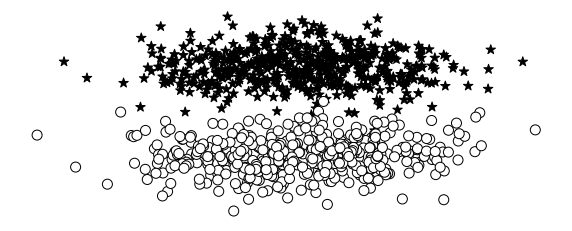

In [21]:
seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

x_data, y_truth = get_toy_data(batch_size=1000)

x_data = x_data.data.numpy()
y_truth = y_truth.data.numpy()

left_x = []
right_x = []
left_colors = []
right_colors =  []

for x_i, y_true_i in zip(x_data, y_truth):
    color = 'black'

    if y_true_i == 0:
        left_x.append(x_i)
        left_colors.append(color)

    else:
        right_x.append(x_i)
        right_colors.append(color)

left_x = np.stack(left_x)
right_x = np.stack(right_x)

_, ax = plt.subplots(1, 1, figsize=(10,4))

ax.scatter(left_x[:, 0], left_x[:, 1], color=left_colors, marker='*', s=100)
ax.scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor=right_colors, marker='o', s=100)

plt.axis('off');

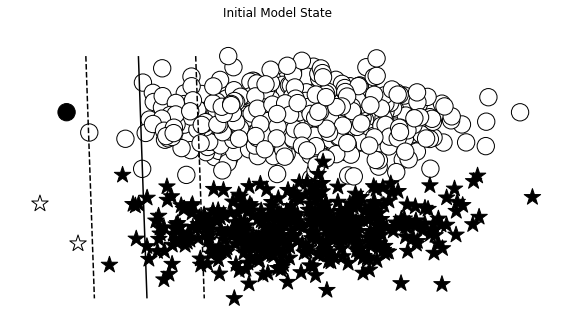

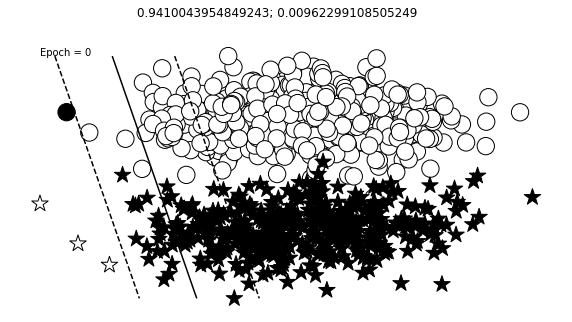

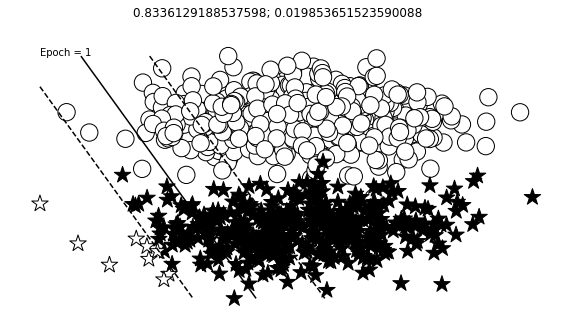

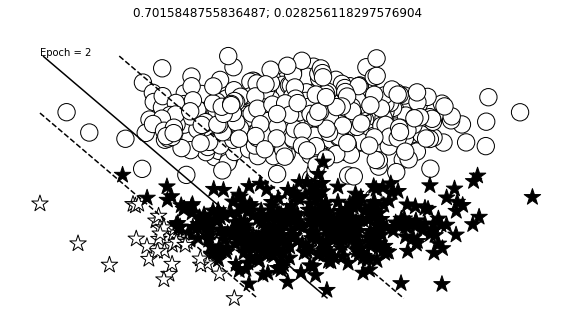

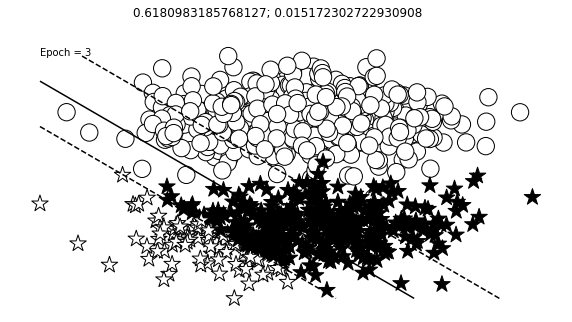

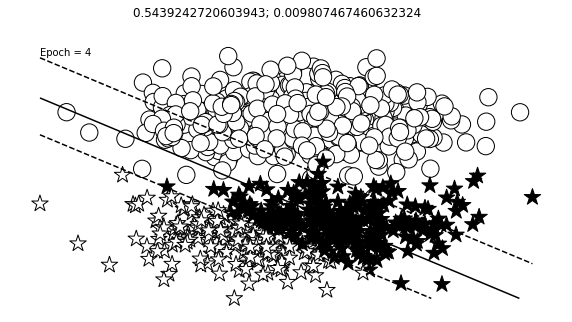

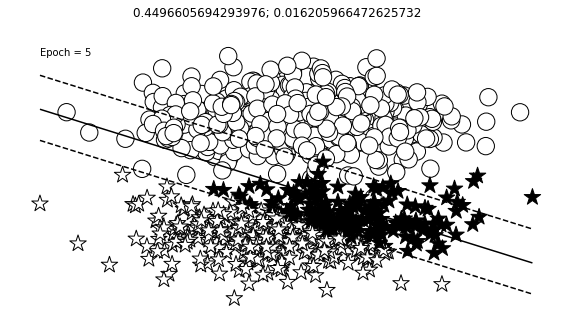

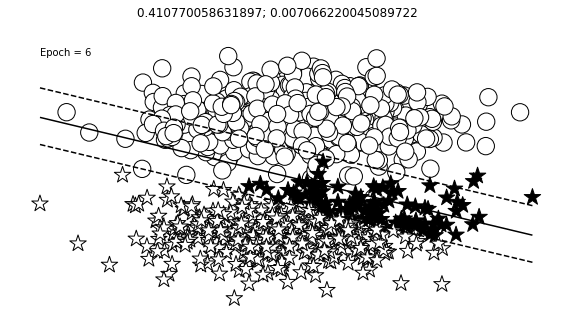

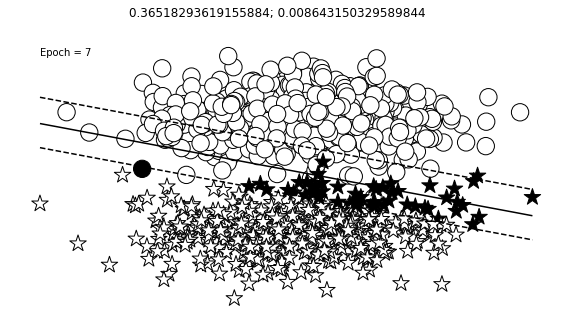

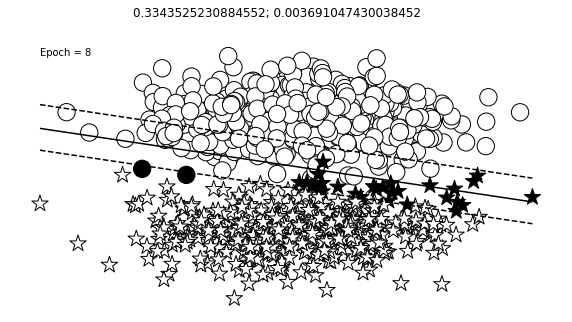

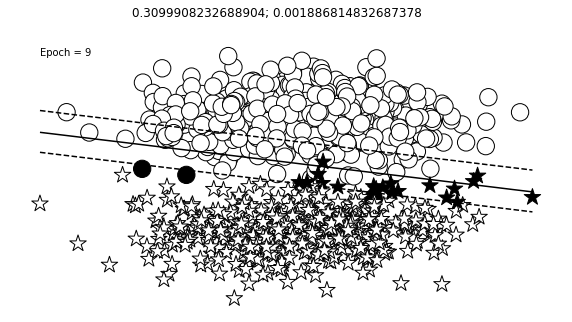

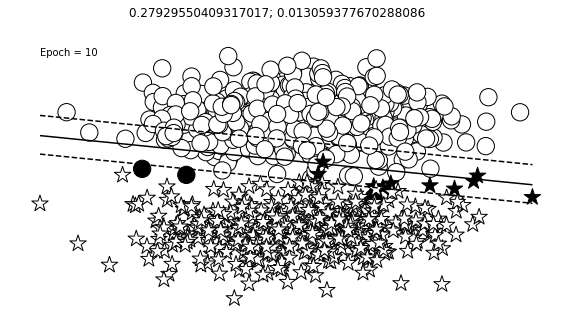

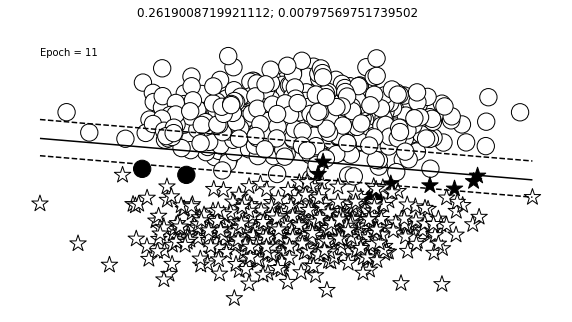

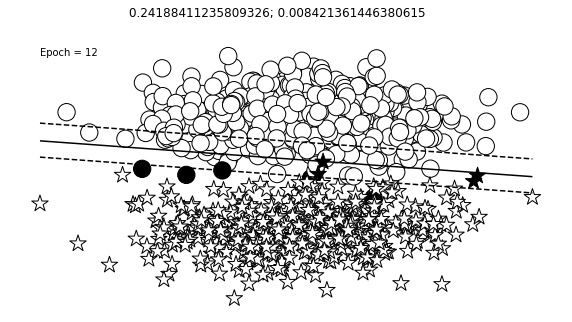

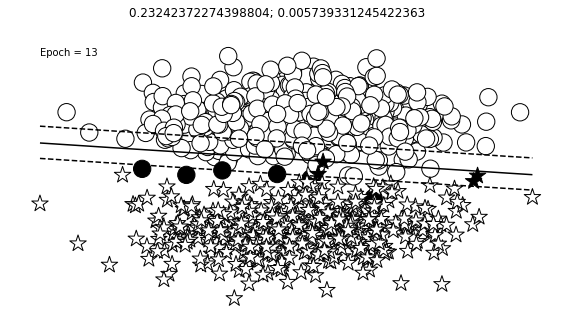

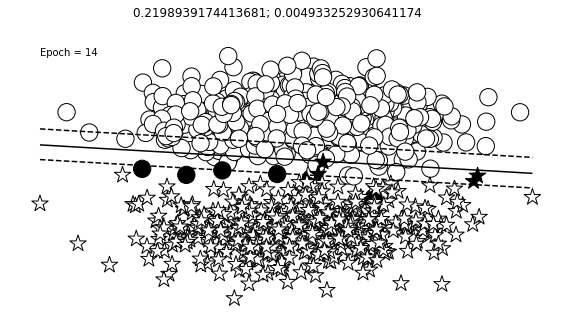

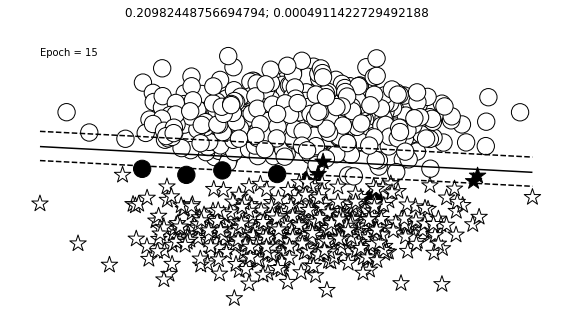

In [22]:
lr = 0.01
input_dim = 2

batch_size = 1000
n_epochs = 12
n_batches = 5

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

perceptron = Perceptron(input_dim=input_dim)
optimizer = optim.Adam(params=perceptron.parameters(), lr=lr)
bce_loss = nn.BCELoss()

losses = []

x_data_static, y_truth_static = get_toy_data(batch_size)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, title='Initial Model State')
plt.axis('off')
#plt.savefig('initial.png')

change = 1.0
last = 10.0
epsilon = 1e-3
epoch = 0
while change > epsilon or epoch < n_epochs or last > 0.3:
    for _ in range(n_batches):

        optimizer.zero_grad()
        x_data, y_target = get_toy_data(batch_size)
        y_pred = perceptron(x_data).squeeze()
        loss = bce_loss(y_pred, y_target)
        loss.backward()
        optimizer.step()
        
        
        loss_value = loss.item()
        losses.append(loss_value)

        change = abs(last - loss_value)
        last = loss_value
               
    fig, ax = plt.subplots(1, 1, figsize=(10,5))
    visualize_results(perceptron, x_data_static, y_truth_static, ax=ax, epoch=epoch, 
                      title=f"{loss_value}; {change}")
    plt.axis('off')
    epoch += 1
    #plt.savefig('epoch{}_toylearning.png'.format(epoch))

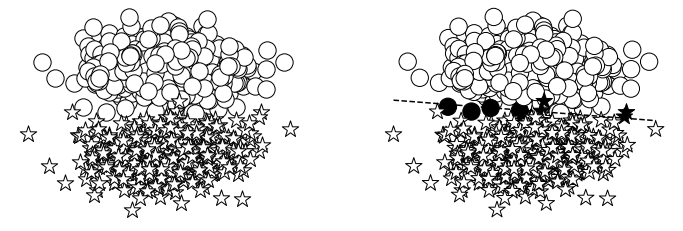

In [23]:
_, axes = plt.subplots(1,2,figsize=(12,4))

axes[0].scatter(left_x[:, 0], left_x[:, 1], facecolor='white',edgecolor='black', marker='o', s=300)
axes[0].scatter(right_x[:, 0], right_x[:, 1], facecolor='white', edgecolor='black', marker='*', s=300)
axes[0].axis('off');
visualize_results(perceptron, x_data_static, y_truth_static, epoch=None, levels=[0.5], ax=axes[1])
axes[1].axis('off');
plt.savefig('perceptron_final.png')
plt.savefig('perceptron_final.pdf')

In [24]:
import numpy as np
import torch
import torch.nn as nn

seed = 1337

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

%matplotlib inline

In [25]:
class Perceptron(nn.Module):
    
    def __init__(self, input_dim):

        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x_in):

        return torch.sigmoid(self.fc1(x_in)).squeeze()


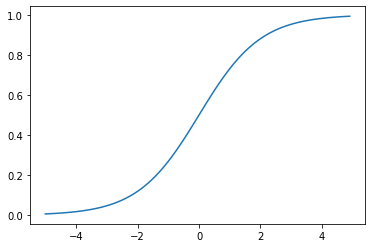

In [26]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-5., 5., 0.1)
y = torch.sigmoid(x)
plt.plot(x.numpy(), y.detach().numpy())
plt.show()

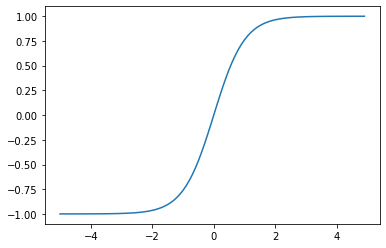

In [27]:
import torch
import matplotlib.pyplot as plt

x = torch.arange(-5., 5., 0.1)
y = torch.tanh(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

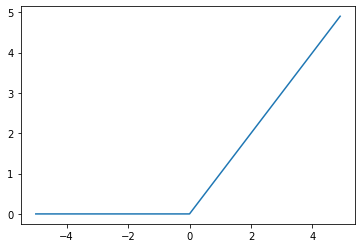

In [28]:
import torch
import matplotlib.pyplot as plt

relu = torch.nn.ReLU()
x = torch.arange(-5., 5., 0.1)
y = relu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

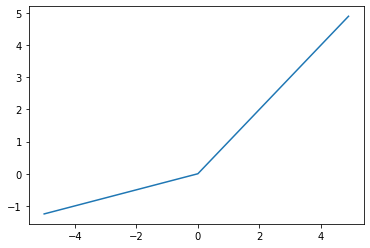

In [29]:
import torch.nn as nn
import matplotlib.pyplot as plt

prelu = nn.PReLU(num_parameters=1)
x = torch.arange(-5., 5., 0.1)
y = prelu(x)

plt.plot(x.numpy(), y.detach().numpy())
plt.show()

In [30]:
softmax = nn.Softmax(dim=1)
x_input = torch.randn(1, 3)
y_output = softmax(x_input)
print(x_input)
print(y_output)
print(torch.sum(y_output, dim=1))

tensor([[-2.0260, -2.0655, -1.2054]])
tensor([[0.2362, 0.2271, 0.5367]])
tensor([1.])


In [31]:
import torch
import torch.nn as nn

mse_loss = nn.MSELoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.randn(3, 5)
loss = mse_loss(outputs, targets)
loss.backward()
print(loss)

tensor(1.6031, grad_fn=<MseLossBackward>)


In [32]:
import torch
import torch.nn as nn

ce_loss = nn.CrossEntropyLoss()
outputs = torch.randn(3, 5, requires_grad=True)
targets = torch.tensor([1, 0, 3], dtype=torch.int64)
loss = ce_loss(outputs, targets)
loss.backward()
print (loss)

tensor(2.5949, grad_fn=<NllLossBackward>)


In [33]:
bce_loss = nn.BCELoss()
sigmoid = nn.Sigmoid()
probabilities = sigmoid(torch.randn(4, 1, requires_grad=True))
print(probabilities)

targets = torch.tensor([1, 0, 1, 0], dtype=torch.float32).view(4, 1)
loss = bce_loss(probabilities, targets)
loss.backward()
print(loss)

tensor([[0.7411],
        [0.5622],
        [0.8286],
        [0.6569]], grad_fn=<SigmoidBackward>)
tensor(0.5958, grad_fn=<BinaryCrossEntropyBackward>)
